In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# %reload_ext autoreload
# %autoreload 2

import numpy as np
from matplotlib import pyplot as plt

from vectran import data
from vectran.data.syndata.datasets import SyntheticHandcraftedDataset
from vectran.data.syndata.utils import renormalize as _normalize_probas
from vectran.data import graphics_primitives
from vectran.data.graphics_primitives import PrimitiveType

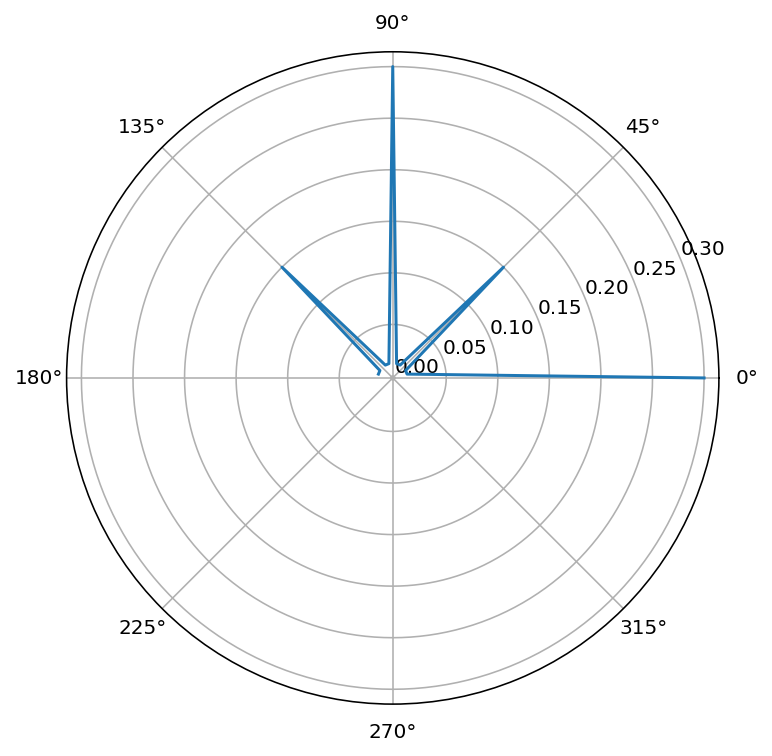

In [2]:
topologies_with_probas = _normalize_probas({
    'l': 1,
    'l-beam': 1,
    'l-outer': 1,
    't': 1,
    't-beam': 1,
    't-outer': 1,
    'x': 1,
    'x-beam': 1,
    'x-outer': 1,
})

strokes_probas = _normalize_probas({1: .45, 2: .45, 3: .1})

directions_probas = {}
for angle in np.linspace(0, np.pi, 13):
    if angle in [0, np.pi / 2]:                 # - horizontal, | vertical
        directions_probas[angle] = .30
    elif angle in [np.pi / 4, np.pi * 3 / 4]:   # /, \
        directions_probas[angle] = .15
    elif angle < np.pi:
        directions_probas[angle] = .1 / 8

directions_probas = _normalize_probas(directions_probas)

## def get_offset_angles():
##     rotations = [0, 90, 180, 270]
##     max_rot_deviation = 10
##     rotations += [base_rot + dev_rot * dev_sign for dev_rot in range(1, max_rot_deviation + 1, 1) for base_rot in (0, 90, 180, 270) for dev_sign in (1, -1)]
##     return rotations
def get_offset_angles():
    return range(0, 360, 4)
offset_directions_probas = _normalize_probas({np.deg2rad(angle): 1 for angle in get_offset_angles()})

# plot distribution of directions
directions, probas = zip(*directions_probas.items())

plt.figure(figsize=(6, 6))
plt.subplot(111, projection='polar')
plt.plot(directions, probas)
plt.show()

In [3]:
padding_factor = 2

patch_parameters = {
    'patch_width': 64,
    'patch_height': 64,
    'max_lines': 10,
    'max_curves': 0
}

syn_parameters = {
    'samples_n': 1000000,
    'border': 8,
    'min_directions': 1, 'max_directions': 2,   
    'min_primitives_gap': 2, 'max_primitives_gap': 10,
    'min_stroke_width': 1, 'max_stroke_width': 7,
    'min_stroke_length': max(patch_parameters['patch_width'], patch_parameters['patch_height']) * .90 * padding_factor,
    'max_stroke_length': np.sqrt(patch_parameters['patch_width']**2 + patch_parameters['patch_height']**2) * padding_factor,
    'primitives_endpoint_noise_sigma': 0.5,
    'primitives_direction_noise_sigma': np.pi / 270.,
    'directions_probas': directions_probas,
    'offset_directions_probas': offset_directions_probas,
    'strokes_probas': strokes_probas,
}

random_seed = 78

In [4]:
# make primitive_types and max_primitives dicts based on the parameters
primitive_types = []
max_primitives = {}
if patch_parameters['max_lines'] > 0:
    primitive_types.append(graphics_primitives.PrimitiveType.PT_LINE)
    max_primitives[graphics_primitives.PrimitiveType.PT_LINE] = patch_parameters['max_lines']
if patch_parameters['max_curves'] > 0:
    primitive_types.append(graphics_primitives.PrimitiveType.PT_BEZIER)
    max_primitives[graphics_primitives.PrimitiveType.PT_BEZIER] = patch_parameters['max_curves']


# initialize syndataset
np.random.seed(random_seed)
syn_dataset = SyntheticHandcraftedDataset(
    patch_size=(patch_parameters['patch_width'], patch_parameters['patch_width']), normalize_image=True,
    primitive_types=primitive_types, max_primitives=max_primitives, size=syn_parameters['samples_n'],
    topologies_with_probas=topologies_with_probas, **syn_parameters)

In [5]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%reload_ext autoreload
%autoreload 2

from contrib.differentiable_rendering.sigmoids_renderer.renderer import Renderer
from utils import (
    SyntheticPatch, LinePerturbationPipe, LineRandomShift, LineClip,
    compute_pixel_coords, compute_pixel_density, get_pixel_coords_and_density, wrap_lines_into_numpy_batch,
    torch_to_synthetic_lines
)
from optimize import optimize_line_batch

from matplotlib import pyplot as plt
import numpy as np
import torch

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Yellow lines are perturbed/transported
Gray background lines are ground truth


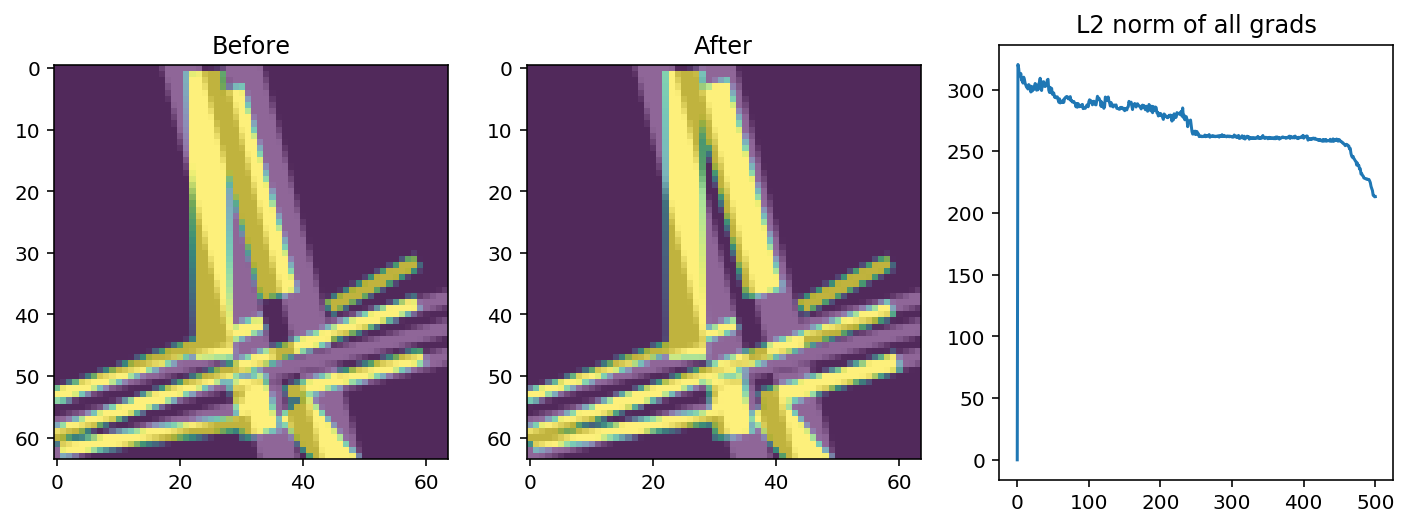

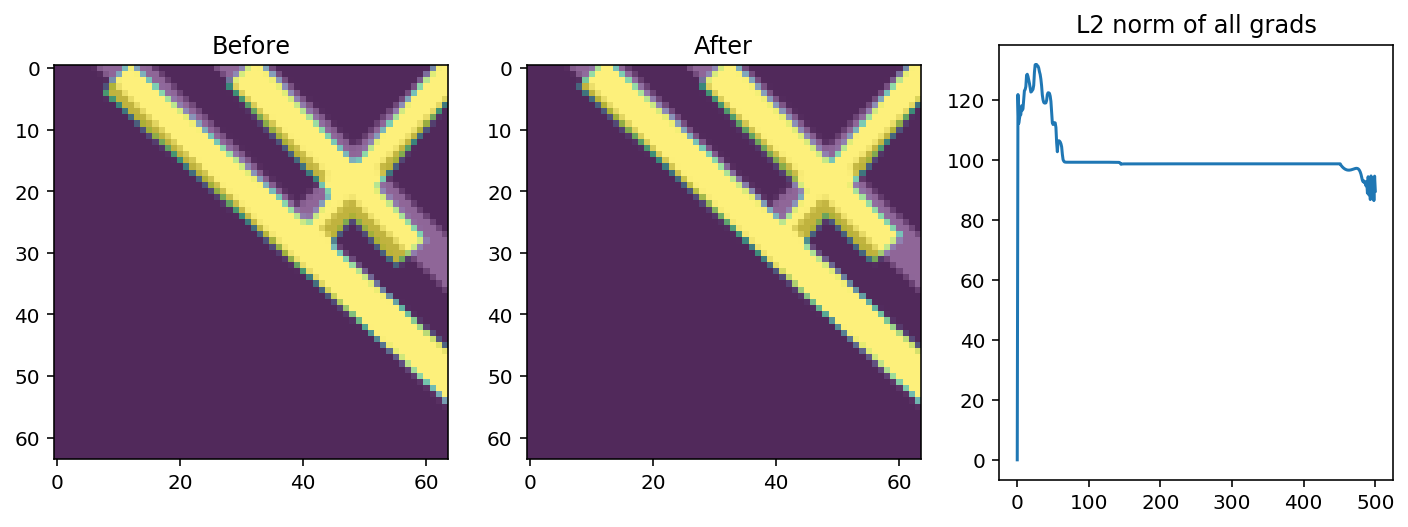

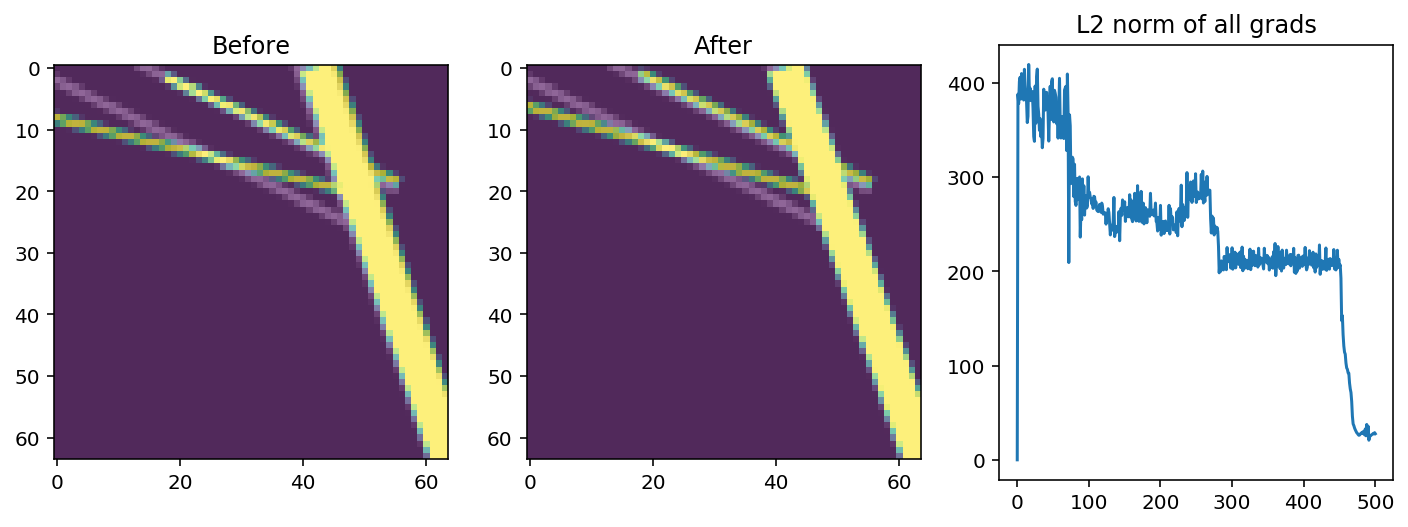

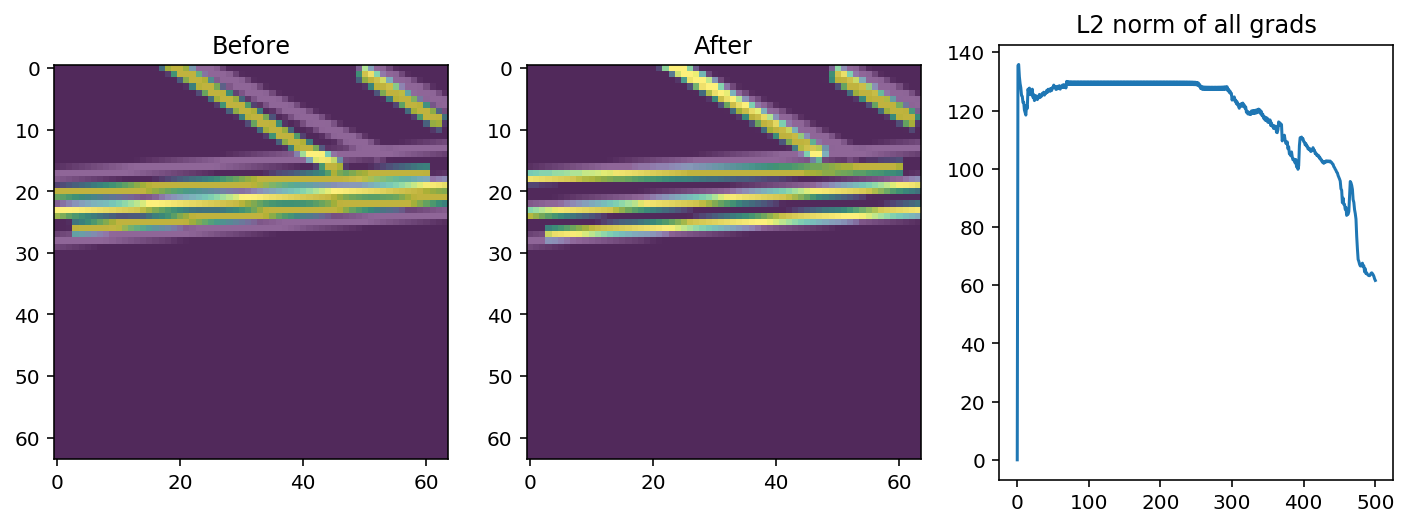

/home/apankov/FloorplanVectorization/vectran/util/geometric.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  r = q / p


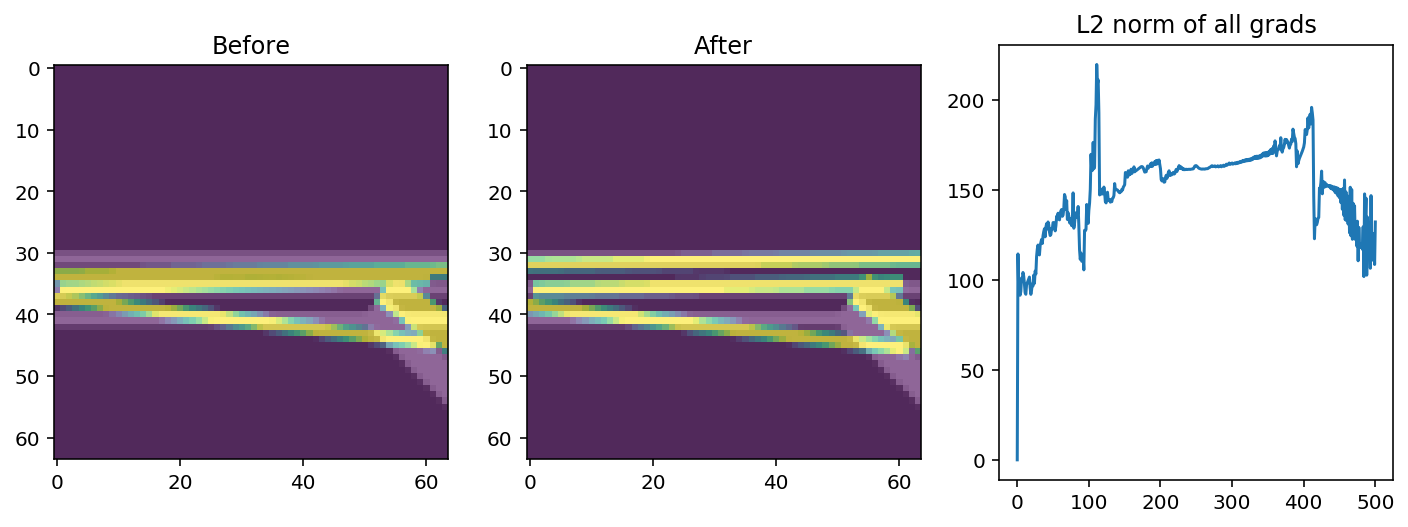

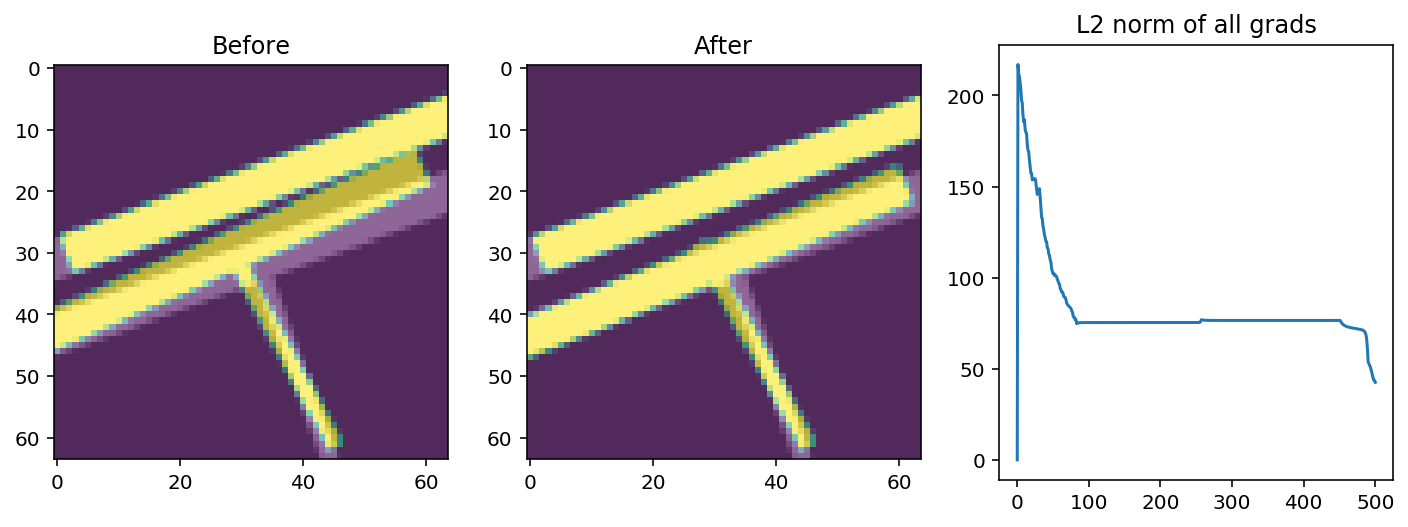

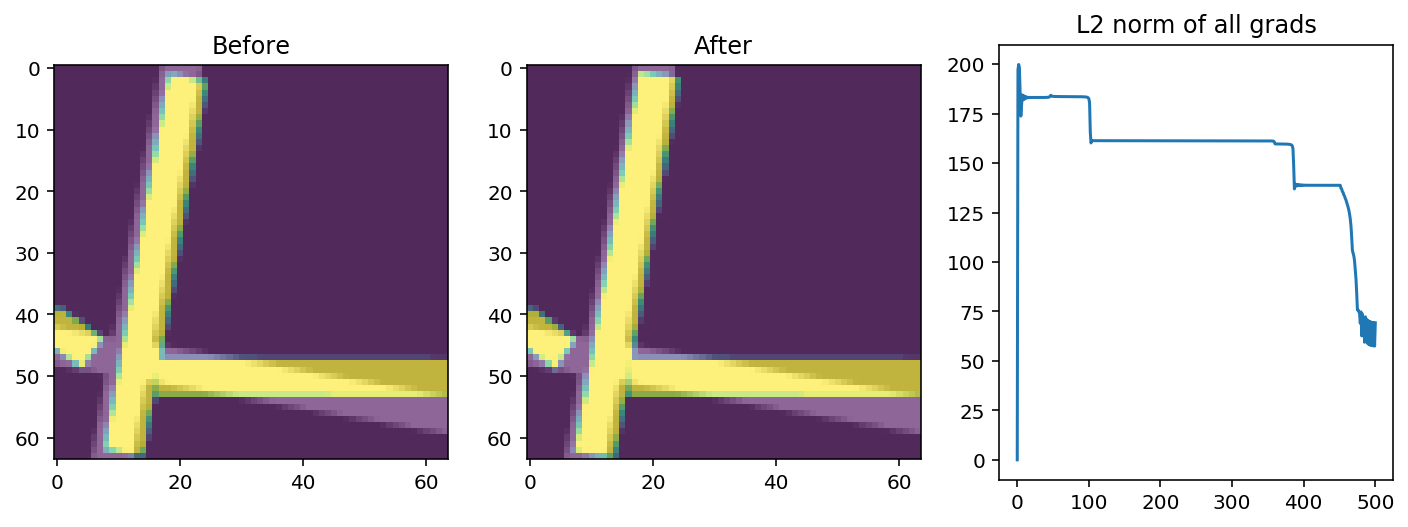

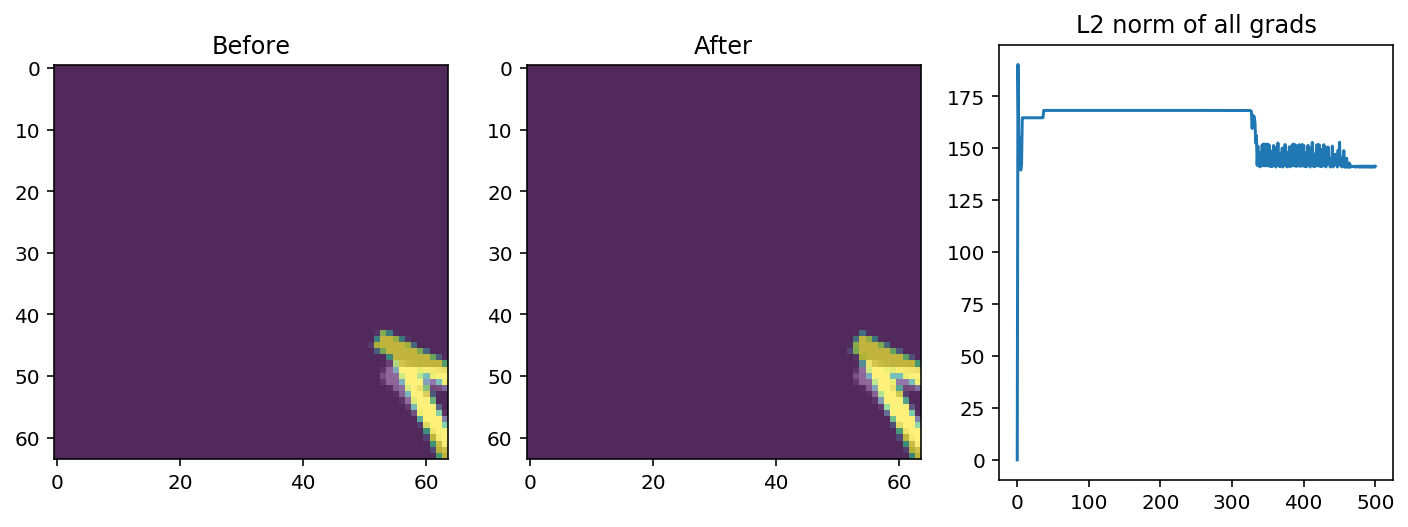

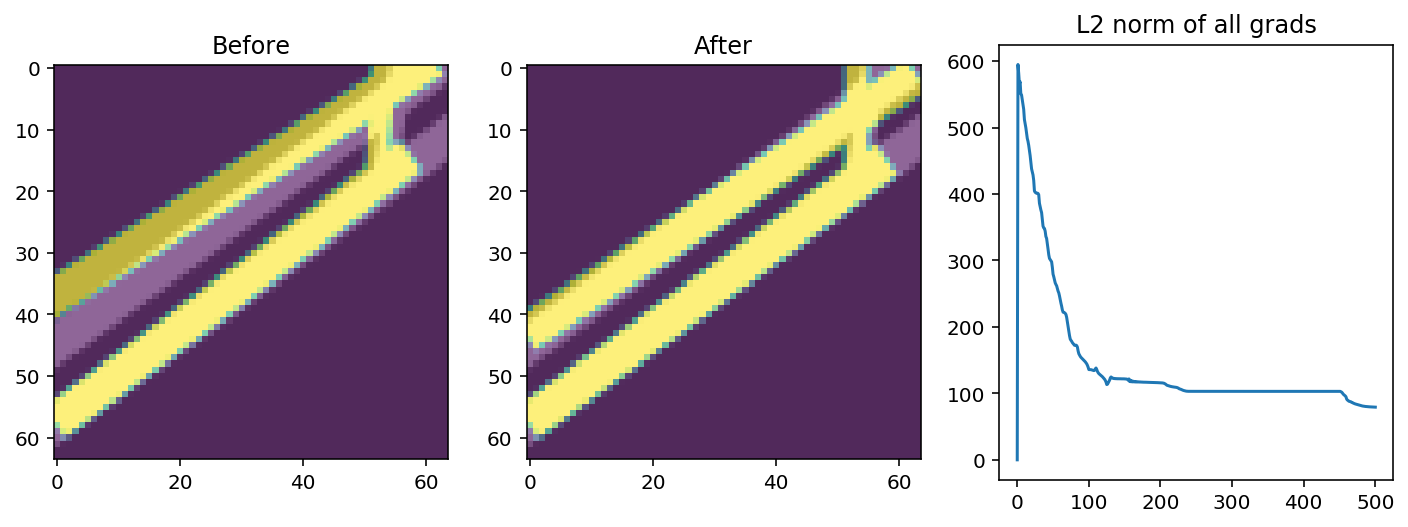

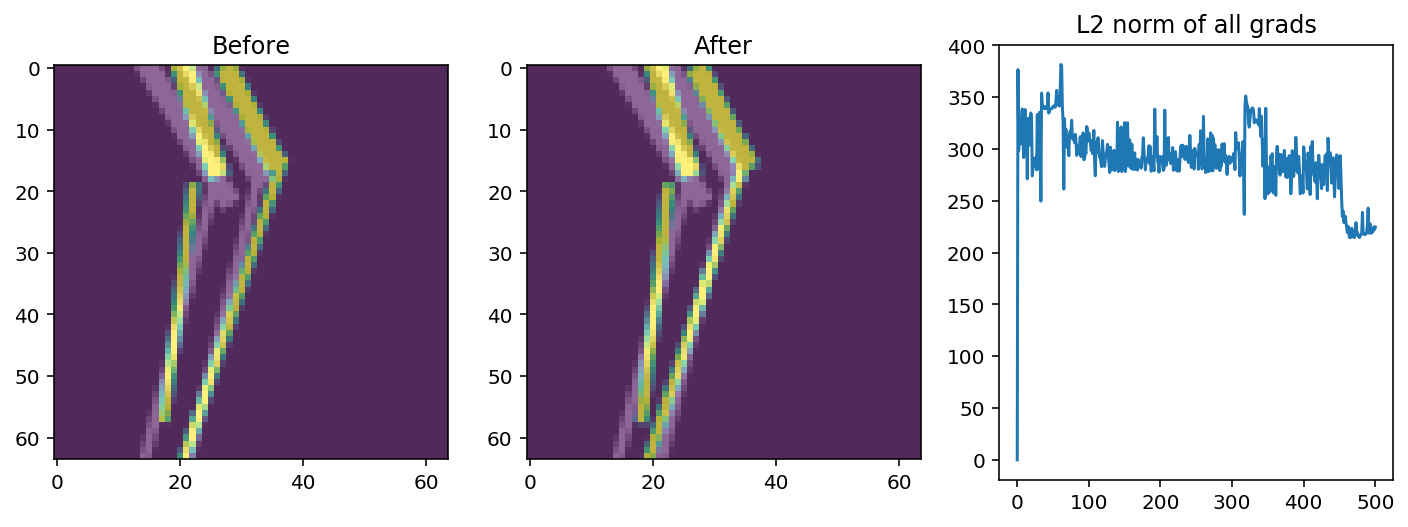

In [6]:
perturber = LinePerturbationPipe(
    LineRandomShift((-6, 6), (0, 1), 4),
#     LineClip(0, 63, 0, 63)
)

renderer = Renderer((64, 64), dtype=torch.float32, device=DEVICE)

print('Yellow lines are perturbed/transported')
print('Gray background lines are ground truth')

for random_seed in range(10):
    sample = syn_dataset[random_seed]
    
    vectors = sample['vector'][PrimitiveType.PT_LINE]
    vectors = vectors[vectors.sum(axis=1) != 0][:, :5]

    perturbed_lines = perturber.transform(vectors)
    perturbed_batch = wrap_lines_into_numpy_batch(perturbed_lines)
    image = 1 - sample['raster']
    raster_coords, raster_masses = get_pixel_coords_and_density(image)
    grads = []
    optimized, steps = optimize_line_batch(torch.from_numpy(perturbed_batch).to(DEVICE),
                                           raster_coords, raster_masses, return_batches_by_step=True, image=image,
                                           lr=0.1, n_iters=500, coord_only_steps=450, width_lr=0.2, ot=1., mse=0.5, grads=grads)
    optimized = optimized.detach().cpu()
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title('Before')
    plt.imshow(image, cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(perturbed_lines).get_image(), alpha=0.6)
    plt.subplot(1, 3, 2)
    plt.title('After')
    plt.imshow(image, cmap='gray', alpha=0.6)
    plt.imshow(SyntheticPatch.from_lines(torch_to_synthetic_lines(optimized[0])).get_image(), alpha=0.6)
    plt.subplot(1, 3, 3)
    plt.title('L2 norm of all grads')
    grad_norms = []
    for grad in grads:
        grad_norms.append(torch.sqrt((grad * grad).sum()))
    plt.plot(grad_norms)
    plt.show()